In [3]:
import numpy as np
import astropy.units as u
import astropy.constants as con
import emcee
import corner
import speclite as speclite; from speclite import filters
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.artist import Artist
from chromatic import *
from scipy.optimize import minimize
from scipy.optimize import curve_fit


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.style.use('seaborn-deep')

## Calculate the scale height

In [ ]:
AB = 0.3 #bond albedo
Teff = 3600
#Teq = ((1-AB)*Teff**4)**(1/4) * u.K #600 * u.K 
Teq = 600 * u.K 
Rp = 4.15 * u.R_earth
Mp = 17 * u.M_earth # other listed values are 11 and 20 Me
mu = 10 # that's for an H2 atmosphere
transit_depth = 0.0512**2
deltaD_atm = (2*con.k_B*Teq*Rp*transit_depth) / (mu * con.m_p * con.G * Mp)

In [ ]:
one_scale_height = deltaD_atm.decompose()

In [ ]:
Rp = one_scale_height/transit_depth + 1
print(Rp)

## Calculate AU Mic's T$_{\rm{eff}}\pm\sigma$T$_{\rm{eff}}$ based on observed luminosity and radius

In [ ]:
L = np.random.normal(0.09,0.02,100000) # Plavchan+ 2009
R = np.random.normal(0.862,0.052,100000) # VLTI measurement
Teff = 5780.0*((L/(R**2))**(1./4.))

In [ ]:
np.median(Teff)

In [ ]:
np.percentile(Teff, [15.9, 50., 84.1])

## Calculate the Doppler-broadened linewidth, $\Delta\lambda$

In [ ]:
vsini = 8.0 * u.km/u.s # from vsini
lambda_i = np.linspace(0.55,0.89,100)*u.micron
delta_lambda = lambda_i * ( (vsini/con.c)/(1.0+(vsini/con.c)) )
delta_lambda = (delta_lambda.decompose()) * 1e9 * u.nm/u.m

plt.figure()
plt.plot(lambda_i,delta_lambda)
plt.xlabel(r'$\lambda_0$ ($\mu$m)')
plt.ylabel(r'$\Delta\lambda$ (nm)')

with Doppler broadening around 0.015-0.024 nm in the NRES bandpass, it is appropriate for us to continue binning the spectra to 0.05 nm so that our binsize accounts for doppler broadening

In [20]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs

In [40]:
nsteps = 3000
modeltype = f'Final_Teff_Phot_Spec'
modelname = 'Teff + Phot + Spec'
visits = ['combined']
orders_I_care_about = [53,58,61,76]

f_kde = [0,0,0,0]
df_kde = [0,0,0,0]
Tspot_kde =[0,0,0,0]             
Tamb_kde = [0,0,0,0]             

i=0
for order in orders_I_care_about:
    visit = visits[0]
    label = f'{visit}_{order}_{modeltype}'
    samples_file_label = label+f'_{nsteps}steps'
    '''
    READ IN THE MCMC SAMPLES
    '''
    reader = emcee.backends.HDFBackend(f'../data/samples/{samples_file_label}.h5')
    sampler = reader.get_chain(discard=int(0.25*nsteps), flat=True)
    samples = sampler.reshape((-1, 4)).T
    
    kde = sm.nonparametric.KDEUnivariate(samples[0])
    kde.fit()  # Estimate the densities
    f_kde[i] = kde

    kde = sm.nonparametric.KDEUnivariate(samples[1])
    kde.fit()  # Estimate the densities
    df_kde[i] = kde   

    kde = sm.nonparametric.KDEUnivariate(samples[2])
    kde.fit()  # Estimate the densities
    Tspot_kde[i] = kde              

    kde = sm.nonparametric.KDEUnivariate(samples[3])
    kde.fit()  # Estimate the densities
    Tamb_kde[i] = kde
    
    i+=1

In [60]:
f_posterior = f_kde[0].density*f_kde[2].density*f_kde[1].density*f_kde[3].density
df_posterior = df_kde[0].density*df_kde[2].density*df_kde[1].density*df_kde[3].density
Tspot_posterior = Tspot_kde[0].density*Tspot_kde[2].density*Tspot_kde[1].density*Tspot_kde[3].density
Tamb_posterior = Tamb_kde[0].density*Tamb_kde[2].density*Tamb_kde[1].density*Tamb_kde[3].density

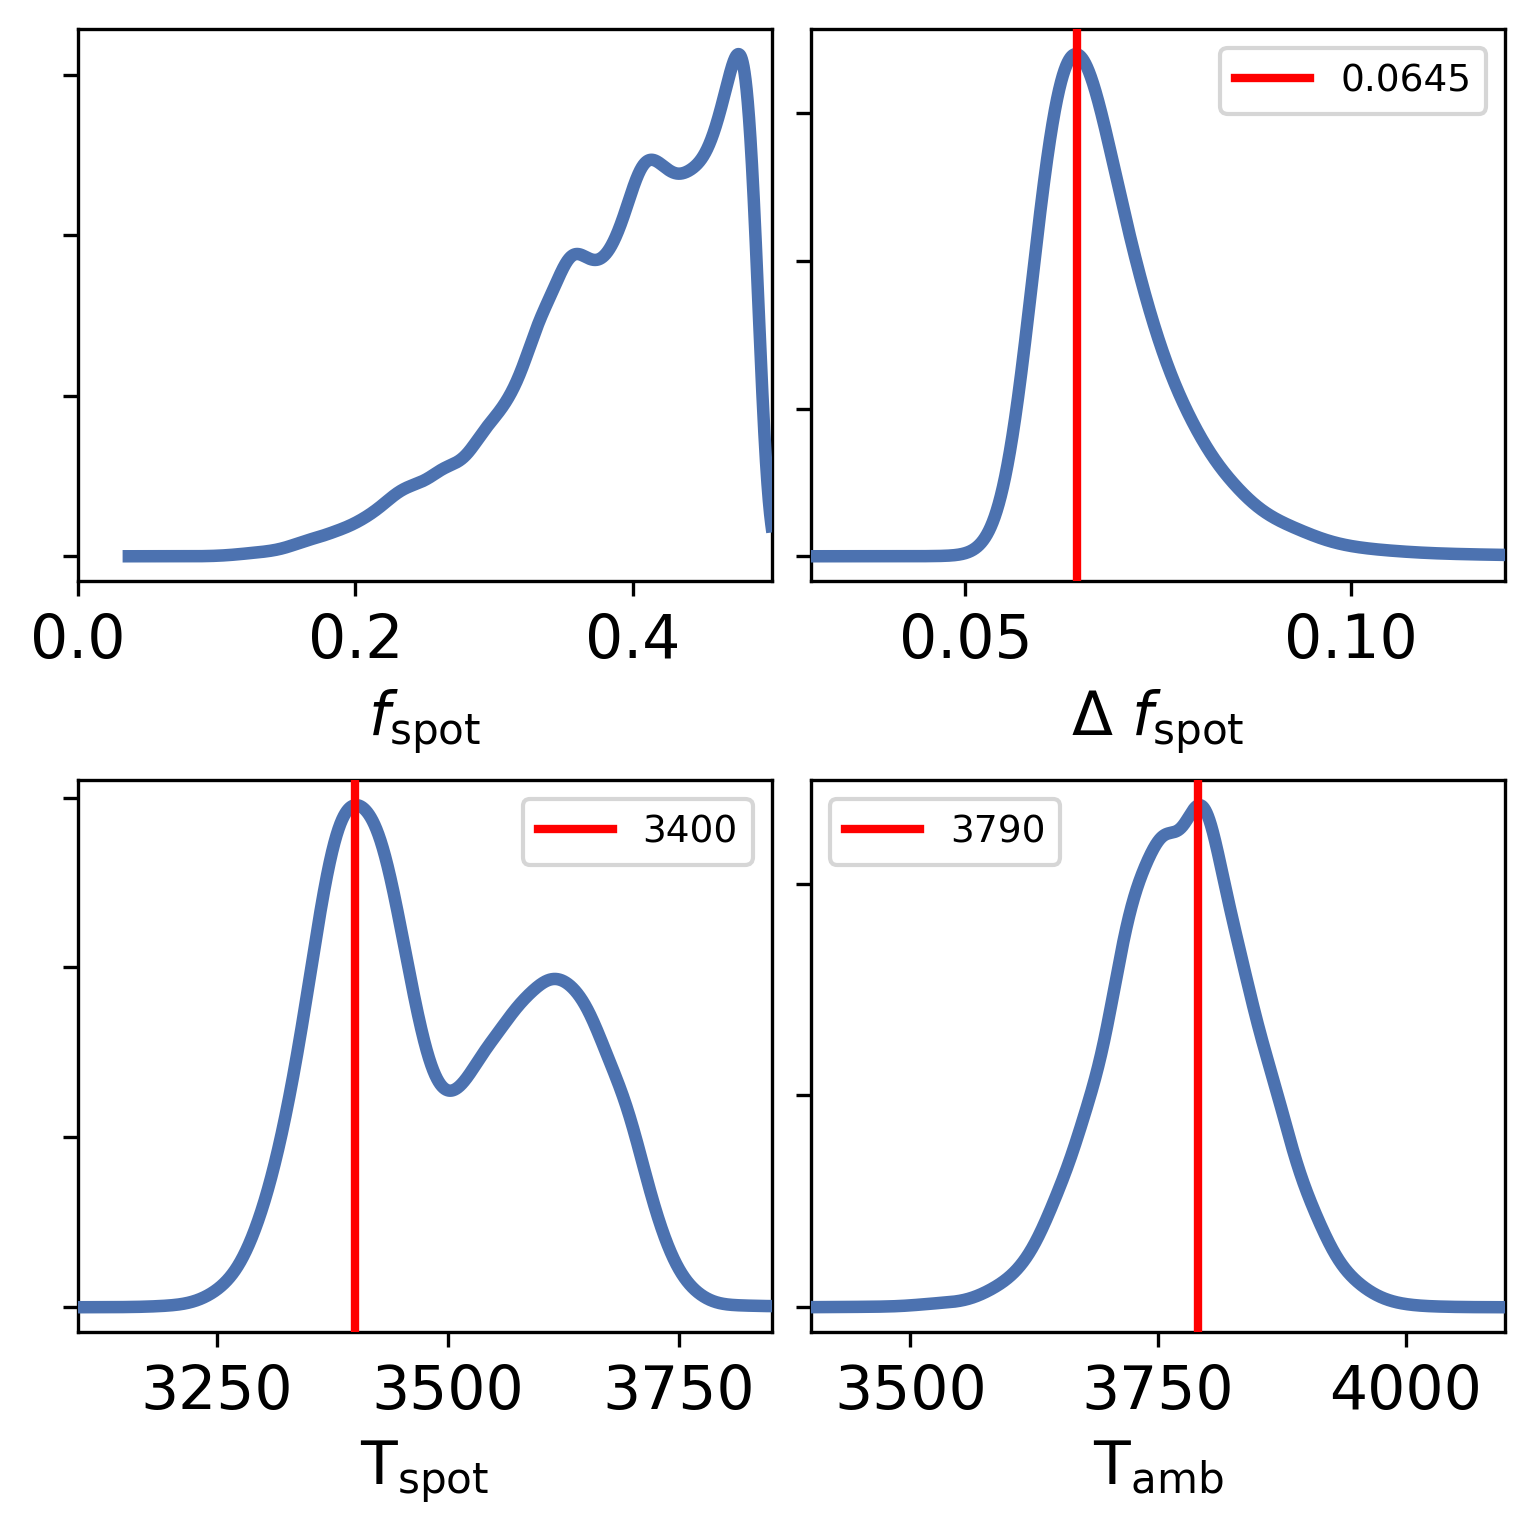

In [84]:
fig,ax = plt.subplots(2,2,figsize=(5,5))

ax[0,0].plot(f_kde[0].support, f_posterior, lw=3, zorder=10)
ax[0,1].plot(df_kde[0].support, df_posterior, lw=3, zorder=10)
ax[1,0].plot(Tamb_kde[0].support, Tspot_posterior, lw=3, zorder=10)
ax[1,1].plot(Tspot_kde[0].support, Tamb_posterior, lw=3, zorder=10)

ax[0,1].axvline(0.0645, lw=2, zorder=100,label='0.0645',color='red')
ax[1,0].axvline(3400, lw=2, zorder=100,label='3400',color='red')
ax[1,1].axvline(3790, lw=2, zorder=100,label='3790',color='red')

ax[0,0].set_xlim(0.0,0.5)
ax[0,0].set_xlabel(r'$f_{\rm spot}$')
ax[0,1].set_xlim(0.03,0.12)
ax[0,1].set_xlabel(r'$\Delta~f_{\rm spot}$')
ax[1,0].set_xlim(3100,3850)
ax[1,0].set_xlabel(r'$\rm T_{spot}$')
ax[1,1].set_xlim(3400,4100)
ax[1,1].set_xlabel(r'$\rm T_{amb}$')

ax[0,0].set(yticklabels=[])
ax[0,1].set(yticklabels=[])
ax[1,0].set(yticklabels=[])
ax[1,1].set(yticklabels=[])

ax[0,1].legend(loc='upper right',fontsize=9)
ax[1,0].legend(loc='upper right',fontsize=9)
ax[1,1].legend(loc = 'upper left',fontsize=9)

plt.savefig('posteriors.png')

In [17]:
combined_Ts = Tspot_samples[0]/3000 * Tspot_samples[1]/3000

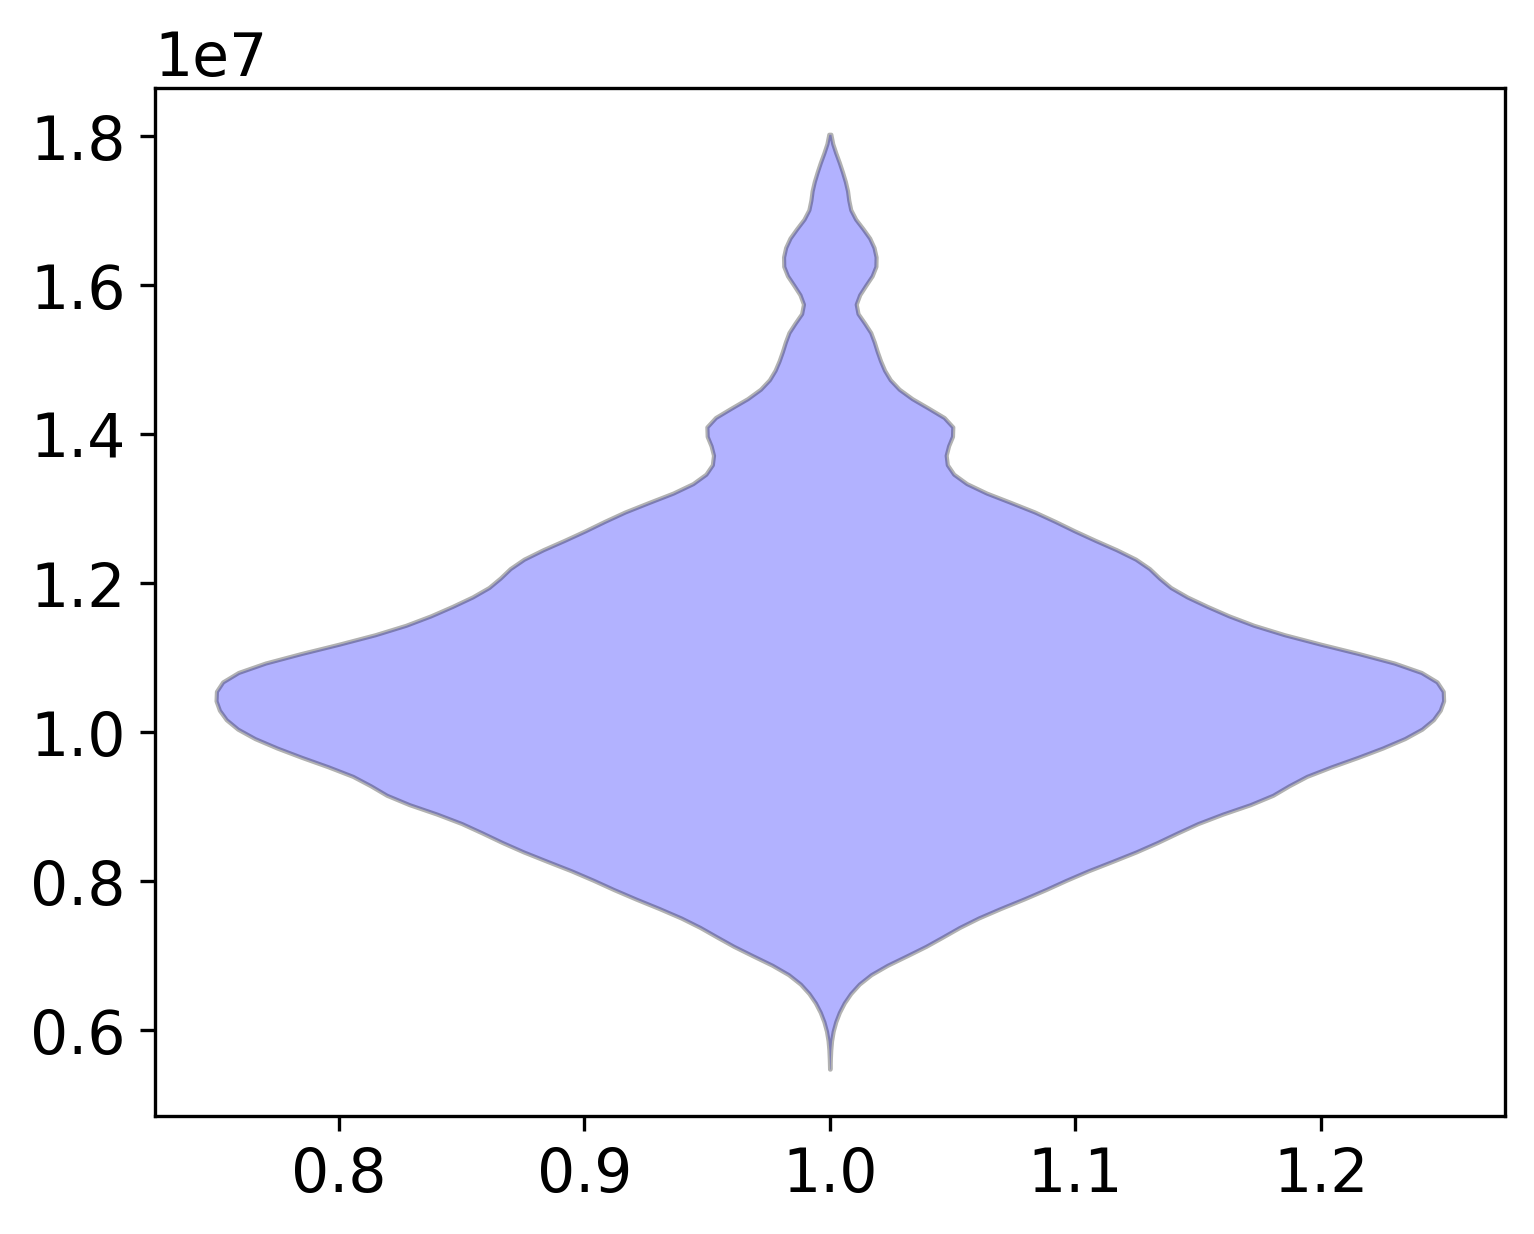

In [18]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
Tspots = ax.violinplot(combined_Ts, positions=[1],showextrema=False, showmedians=False)
for pc in Tspots['bodies']:
    pc.set_facecolor('blue')
    pc.set_label(r'$\rm{T_{spot}}$')
    pc.set_edgecolor('black')
    # pc.set_alpha(alpha)